In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('icsd_scripts/')

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import quantities as pq
from scipy import signal
import json

import icsd

from scipy.ndimage import gaussian_filter

In [4]:
nchan = 51                                          # Number of channels on probe in simulation
channels = np.arange(nchan)                         # list of channels

trial_dur = 1000                                    # Duration one trial (ms)
ntrials = 10                                        # Number of trials
nstim_types = 2                                     # Number of different stimuli - ON (White) and OFF (Black) flash
stimtype_list = [0, 1]                              # 0 = white, 1 = black

tstim_onset = 500                                   # Time of stimulus onset in each trial (ms)
tstim_dur = 250                                     # Duration stimulus in each trial (ms)
ncell_types = 21                                    # Number of different cell types

stim_name_plot = ['White Flash', 'Black Flash']     # To use for titles of figures
stim_name_filename = ['white_flash', 'black_flash'] # To use for saving figures

In [5]:
sim_data_dir = '/Users/atleeskelandrimehaug/Dropbox (Simula)/scripts_for_bmtk/data_files/sim'

In [6]:
# for plotting
plotting = True
plt.rcParams.update({'font.size': 16})

### Load processed, trial averaged LFP
- Averaged over trials
- Shape = (2, 51, 1000), where
    - 2: Two stimulus types; White flash (0), black flash (1)
    - 1000: Trial duration (ms)
    - 51: number of channels on probe where 0 is closest to top of brain and 51 is closest to tip of probe.

In [7]:
filename = 'mod_21_jan_20/lfp_trial_avg.npy'

In [8]:
loadpath = os.path.join(sim_data_dir, filename)
lfp = np.load(loadpath)

### Subtract baseline

In [9]:
for istim in range(nstim_types):
    for ch in range(nchan):
        lfp[istim,:,ch] -= np.mean(lfp[istim,:tstim_onset,ch], axis = 0)

#### Plot LFP to check that it's correct

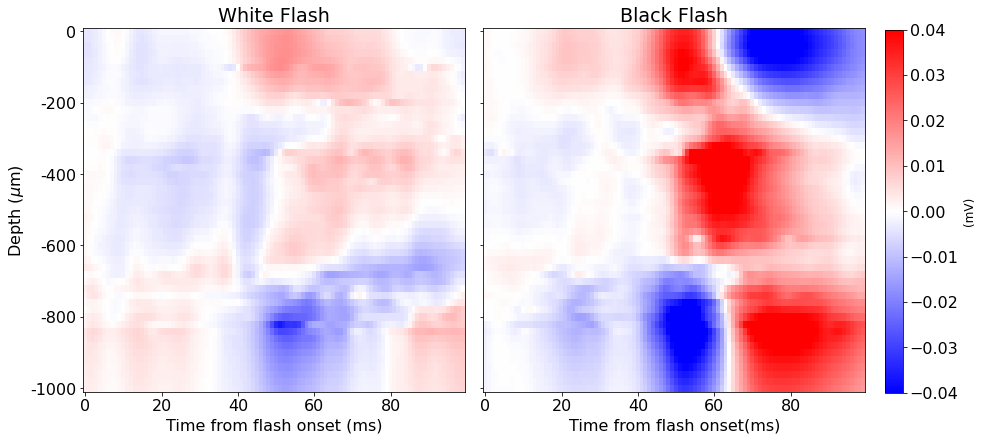

In [10]:
if plotting:
    color_min = -0.04
    color_max = 0.04
    fig, ax = plt.subplots(ncols = 2, figsize = (12,6), constrained_layout = True)
    
    im = ax[0].imshow(lfp[0, tstim_onset:(tstim_onset+100)].T, vmin = color_min, vmax = color_max, cmap = 'bwr')
    im = ax[1].imshow(lfp[1, tstim_onset:(tstim_onset+100)].T, vmin = color_min, vmax = color_max, cmap = 'bwr')
    
    ax[0].set_aspect('auto')
    ax[1].set_aspect('auto')
    
    ax[0].set_title(stim_name_plot[0])
    ax[1].set_title(stim_name_plot[1])
    
    ax[0].set_yticklabels([0, 0, -200, -400, -600, -800, -1000])
    ax[1].set_yticklabels([])
    
    ax[0].set_ylabel('Depth ($\mu$m)')
    
    ax[0].set_xlabel('Time from flash onset (ms)')
    ax[1].set_xlabel('Time from flash onset(ms)')
    
    cbaxes = fig.add_axes([1.02, 0.10, 0.02, 0.84])
    cb = fig.colorbar(im, ax = ax[1], cax = cbaxes); 
    cb.set_label('(mV)', fontsize = '12')

## Set parameters for the CSD

In [11]:
#patch quantities with the SI unit Siemens if it does not exist
for symbol, prefix, definition, u_symbol in zip(
    ['siemens', 'S', 'mS', 'uS', 'nS', 'pS'],
    ['', '', 'milli', 'micro', 'nano', 'pico'],
    [pq.A/pq.V, pq.A/pq.V, 'S', 'mS', 'uS', 'nS'],
    [None, None, None, None, u'µS', None]):
    if type(definition) is str:
        definition = lastdefinition / 1000
    if not hasattr(pq, symbol):
        setattr(pq, symbol, pq.UnitQuantity(
            prefix + 'siemens',
            definition,
            symbol=symbol,
            u_symbol=u_symbol))
    lastdefinition = definition

In [12]:
z_data = np.linspace(0, 1000E-6, 51) * pq.m       # [m] length of electrode
diam = 800E-6 * pq.m                              # [m] source diameter
h = 20E-6 * pq.m                                  # [m] distance between channels
sigma = 0.3* pq.S / pq.m                          # [S/m] or [1/(ohm*m)] extracellular conductivity
sigma_top = 0.3* pq.S / pq.m                      # [S/m] or [1/(ohm*m)] conductivity on top of cortex

#### Initialize

In [13]:
csd_raw = np.zeros((nstim_types, trial_dur, nchan))
csd_smooth = np.zeros_like(csd_raw)

#### Compute CSD

In [14]:

for istim in range(nstim_types):
    delta_input = {
        'lfp' : lfp[istim].T*1E-6*pq.V, #[uV] --> [V]
        'coord_electrode' : z_data,
        'diam' : diam,
        'sigma' : sigma,
        'sigma_top' : sigma,
        'f_type' : 'gaussian',  # gaussian filter
        'f_order' : (3, 1),     # 3-point filter, sigma = 1.
    }

    csd_dict = dict(
        delta_icsd = icsd.DeltaiCSD(**delta_input),
    
        #Other methods for computing CSD:
        #step_icsd = icsd.StepiCSD(**step_input),
        #spline_icsd = icsd.SplineiCSD(**spline_input),
        #std_csd = icsd.StandardCSD(**std_input),
    )

    for method, csd_obj in list(csd_dict.items()):
        csd_raw[istim] =  (csd_obj.filter_csd(csd_obj.get_csd())).T

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


#### Smoothing

- Hann filter

In [15]:
win = signal.hann(15)

for istim in range(nstim_types):
    for t in range(trial_dur):
        csd_smooth[istim,t,:] = signal.convolve(csd_raw[istim,t,:], win, mode='same') / sum(win)

- Gaussian filter

In [16]:
for istim in range(nstim_types):
    csd_smooth[istim] = gaussian_filter(csd_raw[istim], sigma = (0,2))

#### Plot

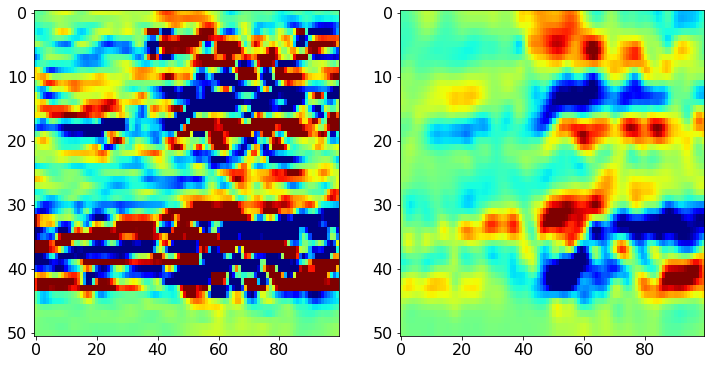

In [17]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,6))

stim_type = 0

cmap_range = 10

ax[0].imshow(csd_raw[stim_type, tstim_onset:(tstim_onset+100)].T*1E6, cmap='jet',aspect='auto', vmin = -cmap_range, vmax = cmap_range)
ax[1].imshow(csd_smooth[stim_type, tstim_onset:(tstim_onset+100)].T*1E6, cmap = 'jet', aspect='auto', vmin = -cmap_range, vmax = cmap_range)

In [56]:
filename = 'mod_21_jan_20/csd_trial_avg_noTempSmooth_15spatSmooth_800umDiam.npy'

In [57]:
save_path = os.path.join(sim_data_dir, filename)
#np.save(save_path, csd_smooth)